# A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import numpy as np
import pandas as pd
import magec_utils as mg
import mimic_utils as mimic
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

pd.set_option('display.max_columns', None)

%matplotlib inline

Using TensorFlow backend.


## MIMIC-III Dataset
The MIMIC-III dataset contains de-identified records from patients admitted in an intensive care unit (ICU) at Beth Israel Deaconess Medical Center in Boston, Massachusetts in the period of June 2001 to October 2012. Following [Ren et al.] we identify non-surgical adult patients admitted at the hospital in ICU for the first time.  A cohort of 10415 patients is extracted for whom laboratory values (19 features), vital signs (8 features), comorbidities (3 features) and demographics (2 features) are measured. For each patient hourly data measurements are computed (with patients having at most 25 different time points) at least 3h prior to an event time (start of intubation or one day after transfer time to ICU for patients who underwent mechanical ventilation support and those who didn’t respectively). 

In [2]:
# MIMIC-III
df = mimic.get_mimic_data()
# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df)
# Data featurized as time-series
df_time = mimic.get_ml_series_data(df)

In [3]:
# train/valid data for 'static' models (MLP/RF/LR)
x_train, x_validation, stsc, xst_train, xst_validation, Y_train, Y_validation = mimic.train_valid_ml(df_ml)

In [4]:
# train/valid data for LSTM
stsc2, df_series_train, df_series_valid, xt_train, Yt_train, \
xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

In [5]:
# Label weights 
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train['label']), Y_train['label'])

### MIMIC-II MV Models
We split our cohort of 10415 patients into a train and validation set (using a 80/20 random split) and apply z-normalization for every feature (at every time point). We train a multi-layer perceptron (MLP), a random forest (RF) with calibrated probabilities using Platt’s method, and a logistic regression (LR) model using latest extracted features and a long-short-term (LSTM) model using all extracted time points. All four models are untuned. We compute MAgECs for each of the 2083 patients in the validation set for all models.

In [6]:
models = mimic.mimic_models(xst_train, Y_train, xt_train, Yt_train, class_weights)

In [7]:
mlp = models['mlp']
rf = models['rf']
lr = models['lr']
lstm = models['lstm']

In [8]:
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc = mg.evaluate(mlp, xst_validation, Y_validation['label'])

Accuracy: 0.864618
Precision: 0.800000
Recall: 0.431655
F1 score: 0.560748
ROC AUC: 0.814234
[[1621   45]
 [ 237  180]]


In [9]:
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = mg.evaluate(rf, xst_validation, Y_validation['label'])

Accuracy: 0.803649
Precision: 0.574074
Recall: 0.074341
F1 score: 0.131635
ROC AUC: 0.817547
[[1643   23]
 [ 386   31]]


In [10]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = mg.evaluate(lr, xst_validation, Y_validation['label'])

Accuracy: 0.662026
Precision: 0.329370
Recall: 0.664269
F1 score: 0.440382
ROC AUC: 0.711991
[[1102  564]
 [ 140  277]]


In [11]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_auc = mg.evaluate(lstm, xt_valid, Yt_valid)

Accuracy: 0.870859
Precision: 0.764286
Recall: 0.513189
F1 score: 0.614060
ROC AUC: 0.846769
[[1600   66]
 [ 203  214]]


In [13]:
en_accuracy, en_precision, en_recall,\
en_f1, en_auc = mimic.mimic_ensemble_metrics(models, xst_validation, Y_validation, xt_valid, df_series_valid)

Accuracy: 0.872780
Precision: 0.830435
Recall: 0.458034
F1 score: 0.590417
ROC AUC: 0.849687
[[1627   39]
 [ 226  191]]


## Model metrics

| Model     | Accuracy | Precision | Recall | F1 score | ROC AUC | Confusion Matrix              |
| :--------:| :------: | :-------: | :-----:| :-------:| :-----: | :---------------------------: |
|  LR       |   0.66   |   0.32    |  0.66  |   0.44   |   0.71  |1102&nbsp;564<br />140&nbsp;&nbsp;277|
|  RF       |   0.80   |   0.57    |  0.08  |   0.13   |   0.81  |1643&nbsp;23<br />386&nbsp;&nbsp;31|
|  MLP      |   0.86   |   0.80    |  0.43  |   0.56   |   0.81  |1621&nbsp;45<br />237&nbsp;180|
|  LSTM     |   0.87   |   0.76    |  0.51  |   0.61   |   0.84  |1600&nbsp;&nbsp;66<br />203&nbsp;&nbsp;214|
|  ENSEMBLE |   0.87   |   0.83    |  0.45  |   0.59   |   0.84  |1627&nbsp;&nbsp;39<br />226&nbsp;&nbsp;191|
<br/>
* note: Model Performance Metrics may slightly differ every time you train the models

### MIMIC-III MAgECs

In [14]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

In [15]:
xy_magec = df_series_valid.copy()
x_magec_cols = list(set(xy_magec.columns) - {'label'})
x_magec = xy_magec[x_magec_cols]
y_magec = xy_magec['label']

magecs_lr = mg.case_magecs(lr, x_magec, model_name='lr')
magecs_lr = mg.normalize_magecs(magecs_lr, features=None, model_name='lr')

magecs_rf = mg.case_magecs(rf, x_magec, model_name='rf')
magecs_rf = mg.normalize_magecs(magecs_rf, features=None, model_name='rf')

magecs_mlp = mg.case_magecs(mlp, x_magec, model_name='mlp')
magecs_mlp = mg.normalize_magecs(magecs_mlp, features=None, model_name='mlp')

magecs_lstm = mg.case_magecs(lstm, x_magec, model_name='lstm', timeseries=True)
magecs_lstm = mg.normalize_magecs(magecs_lstm, features=None, model_name='lstm')

feats = vitals+labs
joined = mg.magec_models(magecs_mlp, magecs_rf, magecs_lr, magecs_lstm, Xdata=x_magec, Ydata=y_magec, features=feats)
joined.to_csv('time_mimic_magecs.csv', index=False)

In [ ]:
# joined = pd.read_csv('time_mimic_magecs.csv')

In [16]:
features = vitals+labs
weights_auc = {'mlp': mlp_auc, 'rf': rf_auc, 'lr': lr_auc, 'lstm': lstm_auc}
weights_recall = {'mlp': mlp_recall, 'rf': rf_recall, 'lr': lr_recall, 'lstm': lstm_recall}
models = ('mlp', 'rf', 'lr', 'lstm')
ranks = mg.magec_rank(joined, rank=len(features), features=features, models=models)
consensus_auc = mg.magec_consensus(ranks, use_weights=True, weights=weights_auc, models=models)
consensus_recall = mg.magec_consensus(ranks, use_weights=True, weights=weights_recall, models=models)
rbos = mg.magec_rbos(ranks, models=models)

## Panel Plots

In [24]:
# joined['magec_positive'] = joined.apply(mg.magec_threshold, args=(features, 0.5, 'lstm', models), axis=1)

In [25]:
# joined['magec_positive'].value_counts()

In [49]:
# joined[(joined['magec_positive'] == 4) & (joined['timepoint'] == 3)].head()

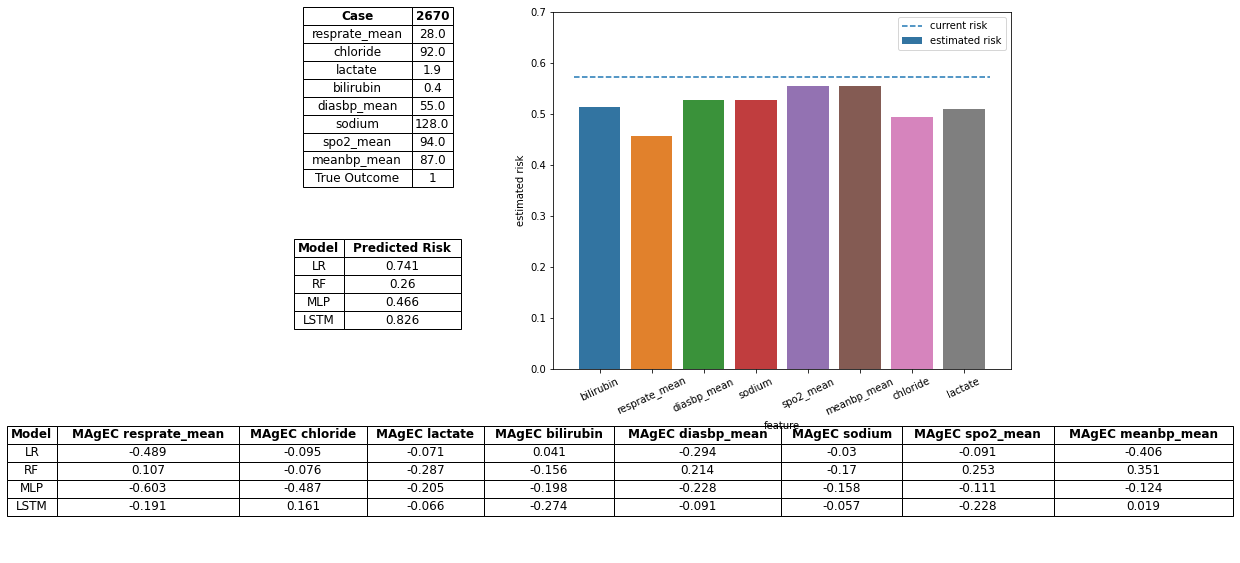

In [50]:
case = 2670
timepoint = 25
mg.panel_plot(xst_train.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)

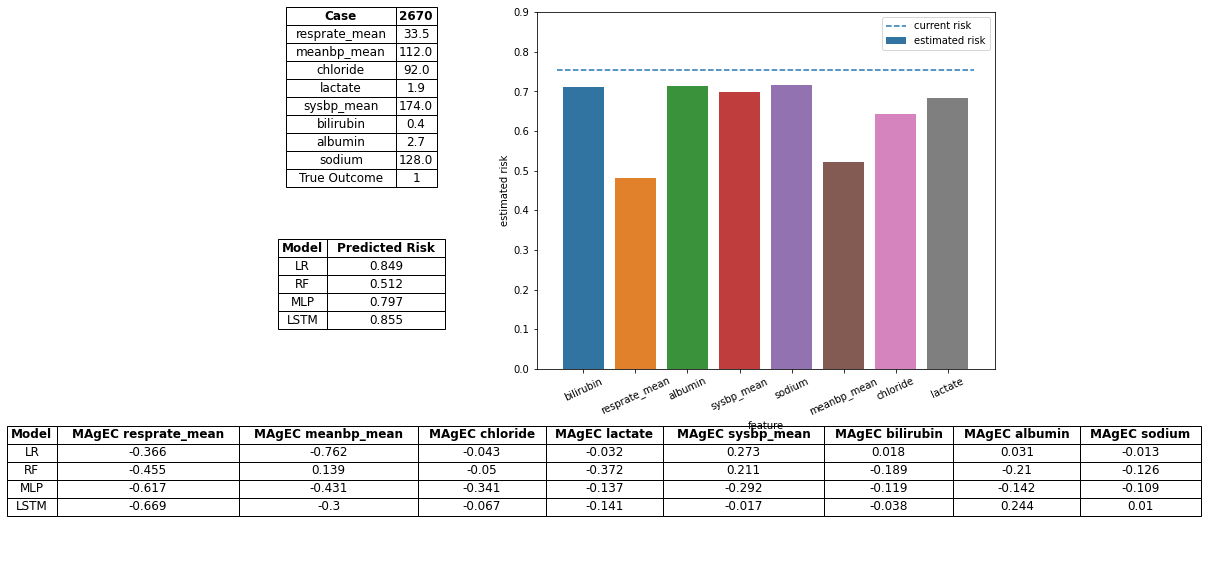

In [51]:
case = 2670
timepoint = 3
mg.panel_plot(xst_train.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)

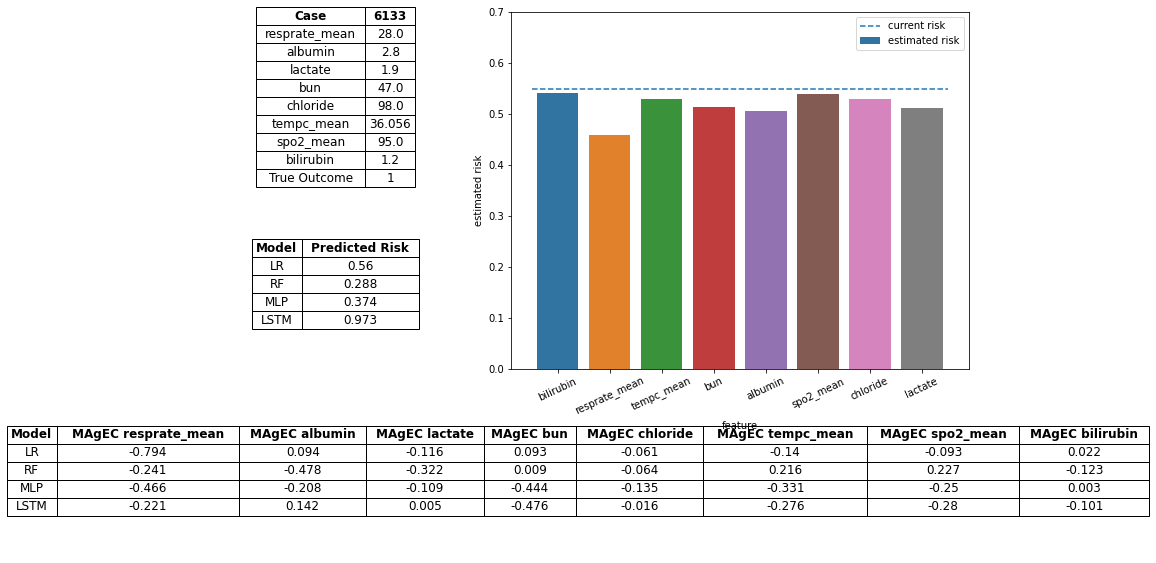

In [52]:
case = 6133
timepoint = 7
mg.panel_plot(xst_train.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)

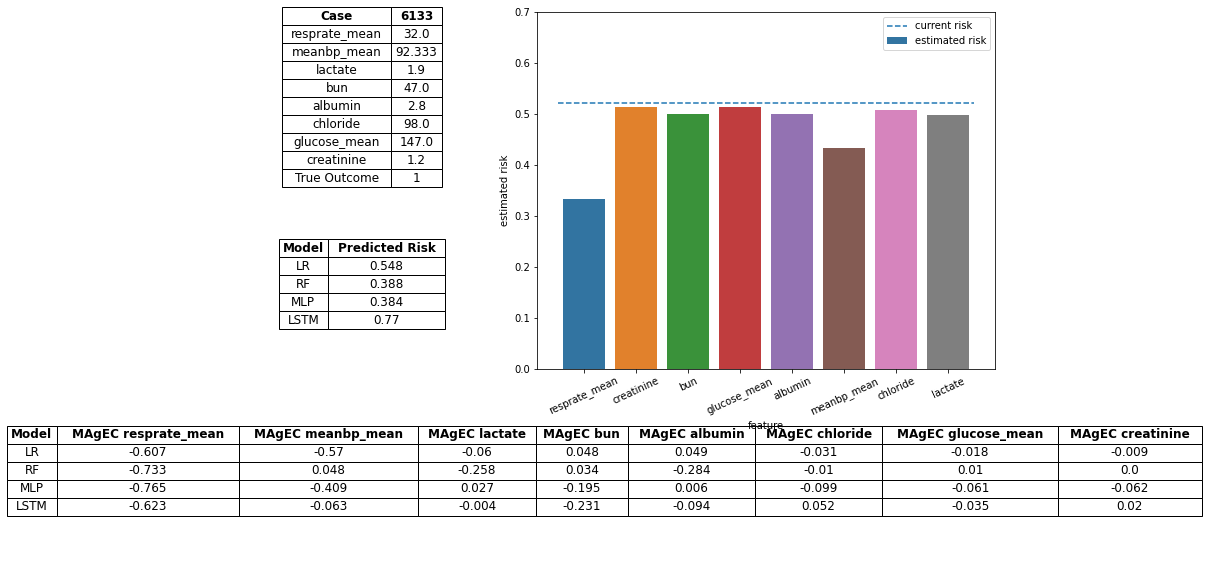

In [53]:
case = 6133
timepoint = 3
mg.panel_plot(xst_train.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)